# Numerical Differentiation

We will roughly follow the treatment in TAK &sect; 3.2.

**Goal:** Given a function $f:{\mathbb R} \to {\mathbb R}$, how to you approximate its derivative?

In [1]:
# Standard Imports
import numpy as np
import matplotlib.pyplot as plt
import math as m
from mpmath import mp, iv

## Loss of precision in subtracting similar numbers

When you subtract numbers that agree to $n$ significant digits of precision, it leads to a loss of significant digits. For example, the following two numbers have $8$ significant digits, but agree to the first three. When we subtract, the resulting number only has $5=8-3$ significant digits:
$$1642.6234 - 1641.6217 = 1.0017.$$
The same of course happens for bits of precision, and for addition when adding two numbers that are nearly negatives of one another.

This issue is called *loss of significance*.

## The definition of the derivative
Recall that the *derivative* of a function $f:{\mathbb R} \to {\mathbb R}$ at $a \in {\mathbb R}$ is
$$f'(a) = \lim_{h \to 0} \frac{f(a+h)-f(a)}{h}.$$
We call $f$ *differentiable at $a$* if this limit exists.

In these notes, you should think of $f$ as a mystery function (since if $f$ is given as a mathematical function, you can probably differentiate it using standard rules).

## Example: Naive Computation

Consider the function $f(x) = e^x \sin x$ at the point $x=2.2$. We know from usual differentiation rules that
$$f'(x)=e^x (\sin x+\cos x)$$
and so $f'(2.2) \approx 1.9854604310541828$ as computed below.

In [2]:
der = m.exp(2.2) * ( m.sin(2.2) + m.cos(2.2) )
der

1.9854604310541828

But suppose we didn't know what our function was. We could attempt to compute the derivative using the approximation 
$$f'(0) \approx \frac{f(h)-f(0)}{h} \quad \text{for $h$ small.}$$
But how small should we make $h$? We will consider what values we get as approximates for values of $h$ of the form $h=2^{-k}$.

In [3]:
def f(x):
    return np.exp(x) * np.sin(x)

Below we show a plot of $f$ near $x=0$. The plot is illustrated with the secant to the graph, a segment joining $\big(0,f(0)\big)$ to $\big(0.5, f(0.5)\big)$ whose slope is the first approximation to the derivative, $\frac{f(0.5)-f(0)}{0.5}$. 

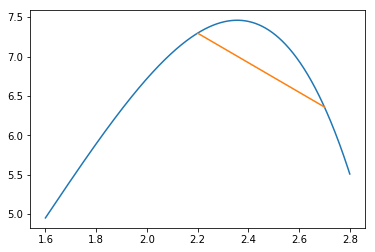

In [4]:
x = np.linspace(1.6, 2.8, 1001)
plt.plot(x, f(x))
plt.plot([2.2, 2.7], [f(2.2), f(2.7)])
plt.show()

Now we will form a table with our $k$ determining $h=2^{-k}$ and our approximation of $f'(0)$. Recall that $f'(0)=1$.

In [5]:
a = 2.2
for k in range(55):
    h = 2**-k
    approx = ( f(a+h) - f(a) ) / h
    error = der - approx
    print("k = {:>2} approx = {:>19} error = {:>10.3e}".format(k, approx, error))

k =  0 approx =  -8.728756395083243 error =  1.071e+01
k =  1 approx = -1.8747859924561432 error =  3.860e+00
k =  2 approx = 0.37579013960446517 error =  1.610e+00
k =  3 approx =  1.2535008533969574 error =  7.320e-01
k =  4 approx =  1.6367941031508337 error =  3.487e-01
k =  5 approx =  1.8153431617279239 error =  1.701e-01
k =  6 approx =  1.9014417757815636 error =  8.402e-02
k =  7 approx =   1.943709353603822 error =  4.175e-02
k =  8 approx =  1.9646492370991382 error =  2.081e-02
k =  9 approx =  1.9750708930669134 error =  1.039e-02
k = 10 approx =  1.9802696734077472 error =  5.191e-03
k = 11 approx =  1.9828660546445462 error =  2.594e-03
k = 12 approx =  1.9841634933982277 error =  1.297e-03
k = 13 approx =  1.9848120248498162 error =  6.484e-04
k = 14 approx =    1.98513624361658 error =  3.242e-04
k = 15 approx =  1.9852983412565663 error =  1.621e-04
k = 16 approx =  1.9853793871006928 error =  8.104e-05
k = 17 approx =   1.985419909353368 error =  4.052e-05
k = 18 app

Observe that the most accurate choice of $h$ is $h=2^{-27}$, and we get the derivative correct to only about $7$ or $8$ significant digits. Below, we see this error in hex, and see this translates to $25$ bits of precision, which is roughly half of the $53$ bits of precision we might expect in a float. (You can convert from number of significant digits to number of significant bits by multiplying by $\log_2 10 \approx 3.3$.) 

In [6]:
a=2.2
k = 27
h = 2**-k
approx = ( f(a+h) - f(a) ) / h
error = der - approx
error.hex()

'0x1.05c2724000000p-25'

First we should discuss why values of $k$ far away from $27$ are so bad:
* If $k$ is small, then the secant line just isn't very close to the graph. This is illustrated in the plot above, where the slope of the secant line doesn't even have the correct sign.
* If $k$ is large, then we suffer from a loss of significance due to the subtraction in our formula.

**Analyzing Loss of Significance**

We will now analyze the error due to loss of significance. We will assume that near $a$, the function $f$ has the property that if $a$ and $a+h$ agree to $n$ significant bits, then $f(a)$ and $f(a+n)$ also agre to $n$ significant bits. This is the case for most well-written functions (but it depends on how a function is implemented on the computer).

Since $a=2.2$, the most significant bit has place value $2^1$. Since $h=2^{-k}$, the bits in place values $2^1, 2^0, \ldots, 2^{1-k}$ all agree between $a$ and $a+h$. Thus $a$ and $a+h$ agree to $k+1$ significant bits. Then by assumption $f(a)$ and $f(a+h)$ agree to $k+1$ significant bits. Thus computing $f(a+h)-f(a)$ results in a loss of $k+1$ significant bits. Since we are working with floats, we expect to have $53 - (k+1)= 52-k$ significant bits remaining. Division by $h$ will not result in any loss of precision (since $h$ is a power of two), so our estimate of $f'(a)$ should be correct to $52-k$ significant bits. Since $1 \leq f'(a)<2$, the place value $2^0$ is the most significant bit. So, we can only expect to be accurate to the bit representing place value $2^{k-51}$. Which means that our expected error should be the same in magnitude as $2^{k-52}$.

For large values of $k$, this explains the error. See the table below. Numbers are written in exponential notation, and observe the exponents roughly match.

In [7]:
a = 2.2
for k in range(30,55):
    h = 2**-k
    approx = ( f(a+h) - f(a) ) / h
    error = der - approx
    expected_error = 2**(k-52)
    print("k = {:>2}   error = {:>10.3e}   expected error = {:.3e}". \
          format(k, error, expected_error))

k = 30   error = -8.040e-07   expected error = 2.384e-07
k = 31   error =  2.057e-06   expected error = 4.768e-07
k = 32   error = -1.758e-06   expected error = 9.537e-07
k = 33   error = -5.572e-06   expected error = 1.907e-06
k = 34   error =  2.057e-06   expected error = 3.815e-06
k = 35   error =  1.732e-05   expected error = 7.629e-06
k = 36   error =  4.783e-05   expected error = 1.526e-05
k = 37   error = -1.320e-05   expected error = 3.052e-05
k = 38   error = -1.353e-04   expected error = 6.104e-05
k = 39   error =  1.089e-04   expected error = 1.221e-04
k = 40   error =  1.089e-04   expected error = 2.441e-04
k = 41   error =  1.085e-03   expected error = 4.883e-04
k = 42   error =  1.085e-03   expected error = 9.766e-04
k = 43   error =  1.085e-03   expected error = 1.953e-03
k = 44   error =  1.085e-03   expected error = 3.906e-03
k = 45   error = -1.454e-02   expected error = 7.812e-03
k = 46   error =  4.796e-02   expected error = 1.562e-02
k = 47   error =  1.105e-01   e

So, $2^{k-52}$ is a pretty good estimate of the error. It is useful to express this in terms of $h=2^{-k}$. We have that
$$\text{error} = 2^{k-52} = \frac{2^{-52}}{h}.$$

## How good is a secant approximation?

The key to understanding how good a secant approximation to the derivative is Taylor's Theorem in the degree one case. Assuming our function is twice differentiable on the interval with endpoints $a$ and $a+h$, Taylor's Theorem says
$$f(a+h) = f(a) + f'(a)h + \frac{f''(y)}{2}h^2$$
for some $y$. Manipulating this formula, we see that
$$\frac{f(a+h)-f(a)}{h} = f'(a) + \frac{f''(y)}{2}h.$$
Assuming $f''(y)$ is nearly constant on the small interval with endpoints $a$ and $a+h$, we see that our error is roughly linear in $h$.

## An improvement 
The formula above actually suggests an improvement. Here is our formula above:
$$\frac{f(a+h)-f(a)}{h} = f'(a) + \frac{f''(y_+)}{2}h,$$
where we have used $y_+$ instead of $y$. Applying the formula to $-h$ as well gives a $y_-$ between $a-h$ and $a$ such that 
$$\frac{f(a)-f(a-h)}{h} = f'(a) - \frac{f''(y_-)}{2}h.$$
Averaging these two formulas gives that
$$\frac{f(a+h)-f(a-h)}{2h} = f'(a) + \left(\frac{f''(y_+)}{4}- \frac{f''(y_-)}{4}\right)h.$$
It may not be clear why this is better. But, recall that we are assuming that $h$ is so small that $f''$ is roughly constant on the interval from $a-h$ to $a+h$. Thus means that the difference $f''(y_+)-f''(y_+)$ is very close to zero.

**A better understanding of the improvement.** Consider applying the degree two Taylor's theorem. It says that 
$$f(a+h) = f(a) + f'(a)h + \frac{f''(a)}{2}h^2 + \frac{f^{(3)}(y_+)}{6}h^3$$
for some $y_+$ between $a$ and $a+h$. Similarly we see that 
$$f(a-h) = f(a) - f'(a)h + \frac{f''(a)}{2}h^2 - \frac{f^{(3)}(y_-)}{6}h^3$$
for some $y_-$ between $a-h$ and $a$. Subtracting the two equations yields:
$$f(a+h)-f(a-h) = 2 f'(a)h + \frac{f^{(3)}(y_+)+f^{(3)}(y_-)}{6} h^3.$$
Simplifying yields that 
$$f'(a) = \frac{f(a+h)-f(a-h)}{2h} - \frac{f^{(3)}(y_+)+f^{(3)}(y_-)}{12} h^2.$$
Again assuming that the third derivative is roughly constant, we see that the error term is roughly proportional to $h^2$. Quadratic ($h^2$) is much better than linear ($h$) since when $h$ is small, $h^2$ is even smaller.

<div style="background: #FFB"><h2>The two-point approximation of the derivative.</h2>
Assuming $f$ has a continuous $3$rd derivative in a neighborhood of $a$, we have 
$$f'(a) = \frac{f(a+h)-f(a-h)}{2h} + {\mathcal O}(h^2) \quad \text{as $h \to 0$.}$$
</div>

**Big O notation** The formula above is an instance of *Big O notation*. The term ${\mathcal O}(h^2)$ can be replaced by a term $E(h)$, which in this case must be 
$$E(h) = f'(a) - \frac{f(a+h)-f(a-h)}{2h}.$$
We say $E(h) \in {\mathcal O}(h^2)$ as $h \to 0$, which indicates that there are constants $M>0$ and a $\delta>0$ such that 
$$|E(h)| < M h^2 \quad \text{whenever $0<|h|<\delta$.}$$
**The notation ${\mathcal O}(h^2)$ is convienient because it captures the concept that the error decays to zero at least as fast as a constant times $h^2$.**

Below we illustrate a two point approximation of $f'(2.2)$, as the slope of the secant line joining $\big(2.2-0.5, f(2.2-0.5)\big)$ to $\big(2.2+0.5, f(2.2+0.5)\big)$.

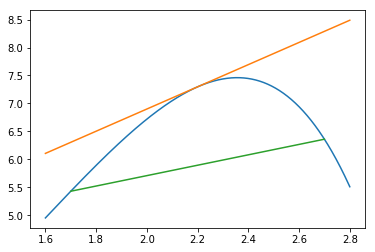

In [8]:
x = np.linspace(1.6, 2.8, 1001)
plt.plot(x, f(x))
plt.plot(x, der*(x-2.2) + f(2.2))
plt.plot([1.7, 2.7], [f(1.7), f(2.7)])
plt.show()

## Example: Testing the two-point approximation

We will test our approximation to the derivative using the same function $f(x) = e^x \sin x$ at the point $x=2.2$. Recall $f'(2.2) \approx 1.9854604310541828$.

We repeat the computation of the table using the new approximation:

In [9]:
a = 2.2
for k in range(55):
    h = 2**-k
    approx = ( f(a+h) - f(a-h) ) / (2*h)
    error = der - approx
    print("k = {:>2} approx = {:>19} error = {:>10.3e}".format(k, approx, error))

k =  0 approx = -2.2632720891695968 error =  4.249e+00
k =  1 approx =   0.930976959843731 error =  1.054e+00
k =  2 approx =  1.7225417638027842 error =  2.629e-01
k =  3 approx =  1.9197780919414065 error =  6.568e-02
k =  4 approx =   1.969042857954257 error =  1.642e-02
k =  5 approx =  1.9813562268478933 error =  4.104e-03
k =  6 approx =   1.984434391832508 error =  1.026e-03
k =  7 approx =  1.9852039219883295 error =  2.565e-04
k =  8 approx =  1.9853963038340225 error =  6.413e-05
k =  9 approx =  1.9854443992521738 error =  1.603e-05
k = 10 approx =  1.9854564231027325 error =  4.008e-06
k = 11 approx =  1.9854594290673049 error =  1.002e-06
k = 12 approx =  1.9854601805564016 error =  2.505e-07
k = 13 approx =  1.9854603684252652 error =  6.263e-08
k = 14 approx =  1.9854604154024855 error =  1.565e-08
k = 15 approx =   1.985460427153157 error =  3.901e-09
k = 16 approx =  1.9854604300635401 error =  9.906e-10
k = 17 approx =  1.9854604308493435 error =  2.048e-10
k = 18 app

Above we see that the best approximation is when $k=18$ and the comptuation yeilds between $10$ and $11$ digits of precision. Here we look at the bits of precision in this case:

In [10]:
k = 18
h = 2**-k
approx = ( f(a+h) - f(a-h) ) / (2*h)
error = der - approx
error.hex()

'0x1.84e4800000000p-34'

We see that we get roughly $34$ bits of precision. We have lost only a third of the bits of precision with this formula.

## Best choice of $h$

With the two-point approximation to $f'(a)$ there the same competing issues: 
* Error due to bad approximation when choosing large $h$.
* Error loss of significance when choosing small $h$. 

Essentially the best choice of $h$ is the one which makes the errors due to these two issues approximately equal. (To see this, note that for example if the greatest error is due to bad approximation, then we should shrink $h$ to make that error decrease. This will result in the error due to loss of significance to increase, but that error is smaller so it matters less.)

Even though we will consider the loss of significance due for the two-point approximation, the error estimate is the almost the same as before, roughly $2^{-52}\big/h$. From our error estimate for the two point method, we see that the error due to bad approximation is roughly $c h^2$ where $c \approx \frac{f^{(3)}(a)}{6}$. We'll just assume $c$ is a reasonably small number. So, we'd like to choose an $h$ such that roughly 
$$\frac{2^{-52}}{h} =  c h^2.$$
Thus, $h^3 = \frac{2^{-52}}{c}$ and so 
$$h=\frac{2^{-17 \frac{1}{3}}}{\sqrt[3]{c}}.$$
Note that we are not interested in getting an exact answer here. We are happy simply to know what magnitude to choose for $h$. Assuming $c$ is a reasonable number, we should choose something the order $h=2^{-17}$, which exactly what we found works best. This will then result in roughly equal error loss to both bad approximation and loss of significance as desired.

The value $h=2^{-17 \frac{1}{3}}$ is pretty close to the $h=2^{-18}$ that we saw worked best when looking at the table.

## The second derivative:

We will now explain how to use Taylor polynomials to estimate the 2nd derivative using three points. Evaluating the degree $2$ Taylor polynomial and considering the error gives that 
$$f(a+h) = f(a) + f'(a)h + \frac{f''(a)}{2}h^2 + \frac{f^{(3)}(y_+)}{6}h^3$$
for some $y_+$ between $a$ and $a+h$, and 
$$f(a-h) = f(a) - f'(a)h + \frac{f''(a)}{2}h^2 - \frac{f^{(3)}(y_-)}{6}h^3$$
for some $y_-$ between $a-h$ and $a$.

Adding the formulas yields:
$$f(a+h) + f(a-h) = 2 f(a) + f''(a) h^2 + \frac{f^{(3)}(y_+)-f^{(3)}(y_-)}{6}h^3.$$
Solving for $f''(a)$, we see that 
$$f''(a) = \frac{f(a+h) - 2 f(a) + f(a-h)}{h^2} - \frac{f^{(3)}(y_+)-f^{(3)}(y_-)}{6}h.$$

This formula looks like it an error of order $h$, but if $f$ is $4$-times differentiable, we can apply the Mean value theorem to conclude that 
$$\frac{f^{(3)}(y_+)-f^{(3)}(y_-)}{y_+-y_-} = f^{(4)}(z)$$
for some $z$ between $y_-$ and $y_+$. Thus, 
$$|f^{(3)}(y_+)-f^{(3)}(y_-)| = (y_+-y_-) |f^{(4)}(z)| \leq 2h |f^{(4)}(z)|.$$
Plugging in, we see that
$$\left|f''(a) - \frac{f(a+h) + 2 f(a) - f(a-h)}{h^2}\right| \leq \frac{|f^{(4)}(z)|}{3} h^2.$$
for some $z \in (-h,h)$. This is summarized below:

<div style="background: #FFB"><h2>The three-point approximation of the 2nd derivative.</h2>
Assuming $f$ has a continuous $4$th derivative in a neighborhood of $a$, we have 
$$f''(a) = \frac{f(a+h) - 2 f(a) + f(a-h)}{h^2} + {\mathcal O}(h^2) \quad \text{as $h \to 0$.}$$
</div>

**Example**

Lets return to the same example, this time to compute $f''(2.2)$. To get an exact computation, we can use calculus. Recall 
$$f'(x)=e^x (\sin x+\cos x).$$
Thus,
$$f''(x)=e^x (\sin x+\cos x) + e^x(\cos x - \sin x)=2 e^x \cos x.$$

In [11]:
a = 2.2
der2 = 2 * m.exp(a) * m.cos(a)
der2

-10.622461055323118

Here is a table computing approximates for $f''(a)$ using for values of $h=2^{-k}$. Note that the smallest error we see is about $10^{-7}$ when $k=13$ or so.

In [12]:
a = 2.2
for k in range(26):
    h = 2**-k
    approx = (f(a+h) + f(a-h) - 2*f(a)) / h**2
    error = der2 - approx
    print("k = {:>2} approx = {:>19} error = {:>10.3e}".format(k, approx, error))

k =  0 approx = -12.930968611827293 error =  2.309e+00
k =  1 approx = -11.223051809199497 error =  6.006e-01
k =  2 approx = -10.774012993586553 error =  1.516e-01
k =  3 approx = -10.660435816711129 error =  3.797e-02
k =  4 approx = -10.631960153709315 error =  9.499e-03
k =  5 approx =  -10.62483616767895 error =  2.375e-03
k =  6 approx = -10.623054854520888 error =  5.938e-04
k =  7 approx = -10.622609506448498 error =  1.485e-04
k =  8 approx =  -10.62249816826079 error =  3.711e-05
k =  9 approx = -10.622470333706588 error =  9.278e-06
k = 10 approx = -10.622463375329971 error =  2.320e-06
k = 11 approx = -10.622461639344692 error =  5.840e-07
k = 12 approx = -10.622461199760437 error =  1.444e-07
k = 13 approx = -10.622461199760437 error =  1.444e-07
k = 14 approx = -10.622460842132568 error = -2.132e-07
k = 15 approx = -10.622461318969727 error =  2.636e-07
k = 16 approx = -10.622459411621094 error = -1.644e-06
k = 17 approx = -10.622467041015625 error =  5.986e-06
k = 18 app

<!-- So the best choice of $h$ is roughly $h=2^{-13}$ or $h=2^{-12}$. We are using $53$ bits of precision, and this is roughly $53/4$. To see why observe that we can express our second derivative formula as
$$\frac{f(a+h) - 2 f(a) + f(a-h)}{h^2}=
\frac{\frac{f(a+h)-f(a)}{h} - \frac{f(a)-f(a-h)}{h}}{h}.$$
You can think of $\frac{f(a+h)-f(a)}{h}$ as an approximation of $f'(a)$ and $\frac{f(a)-f(a-h)}{h}$ as an approximation of $f'(a-h)$. Then we are applying the same formula again, i.e., using 
$$\frac{f'(a)-f'(a-h)}{h}$$
as an approximate for $f''(a)$. So we are applying the definition of the dertivative twice, and each instance results in a loss of half of the digits of precision, with an optimal choice of $h$. So, we want to choose roughly $h=2^{-53/4}$. -->

We can get a better approximation using more points as indicated below.

<div style="background: #FFB"><h2>The five-point approximation of the 2nd derivative.</h2>
Assuming $f$ has a continuous $6$th derivative in a neighborhood of $a$, we have 
$$f''(a) = \frac{-f(a+2h) + 16 f(a+h) - 30 f(a) + 16 f(a-h) - f(a-2h)}{12 h^2} + {\mathcal O}(h^4) \quad \text{as $h \to 0$.}$$
</div>

**Proof:**

<p style="padding-top: 1em; text-indent: 2em;">I will briefly explain how this is obtained. Considering Taylor's theorem for $f(a \pm h)$ we can see that
$$f(a+h)+f(a-h)-2 f(a) = f''(a)h^2 + \frac{f^{(4)}(a)}{12} h^4 + \frac{f^{(5)}(y_1) - f^{(5)}(y_{-1})}{5!}h^5,$$
for some $y_1 \in (a,a+h)$ and $y_{-1} \in (a-h,a)$. Applying the Mean value theorem then tell us that 
$$f^{(5)}(y_1) - f^{(5)}(y_{-1})=(y_1 - y_{-1})f^{(6)}(z_1)$$
for some $z_1 \in (y_{-1}, y_1).$ Then,
$$f(a+h)+f(a-h)-2 f(a) = f''(a)h^2 + \frac{f^{(4)}(a)}{12} h^4 + \frac{(y_1 - y_{-1})f^{(6)}(z_1)}{5!}h^5.$$
</p>

<p style="padding-top: 1em; text-indent: 2em;">
Then substituting $2h$ for $h$, we see that 
$$f(a+2h)+f(a-2h)-2 f(a) = 4 f''(a)h^2 + \frac{4 f^{(4)}(a)}{3} h^4 + \frac{32(y_2 - y_{-2})f^{(6)}(z_2)}{5!}h^5,$$
for some $y_2 \in (a,a+2h)$, $y_{-2} \in (a-2h,a)$, and $z_2 \in (y_{-2},y_2)$.
</p>

<p style="padding-top: 1em; text-indent: 2em;">
Letting $X_1=f(a+h)+f(a-h)-2 f(a)$ and $X_2 = f(a+2h)+f(a-2h)-2 f(a)$, we see that we can remove the degree four term as follows:
$$16 X_1 - X_2 = 12 f''(a)h^2 + \frac{16(y_1 - y_{-1})f^{(6)}(z_1)-32(y_2 - y_{-2})f^{(6)}(z_2)}{5!}h^5.$$
Solving for $f''(a)$, we see that
$$f''(a) = \frac{16 X_1 - X_2}{12 h^2} - \frac{(y_1 - y_{-1})f^{(6)}(z_1)-2(y_2 - y_{-2})f^{(6)}(z_2)}{90}h^3.$$
Now observe that $0<y_1 - y_{-1}<2h$ and $0<y_2 - y_{-2}<4h$. Thus
$$\left|f''(a) - \frac{16 X_1 - X_2}{12 h^2}\right| \leq  \frac{|f^{(6)}(z_1)|+4|f^{(6)}(z_2)|}{45}h^4.$$
This is the error term we want. Observe that
$$16 X_1 - X_2 = -f(a+2h) + 16 f(a+h) - 30 f(a) + 16 f(a-h) - f(a-2h),$$
so this gives us our result. **QED**
</p>

**Example**

Here is a table computing approximates for $f''(a)$ using the five point formula for values of $h=2^{-k}$. Note that the smallest error we see is about $10^{-10}$ when $k=9$ or so. This is a bit better than the three point fomula.

In [14]:
a = 2.2
for k in range(26):
    h = 2**-k
    approx = (-f(a+2*h) + 16*f(a+h) -30 *f(a) + 16*f(a-h) - f(a-2*h)) / (12*h**2)
    error = der2 - approx
    print("k = {:>2} approx = {:>19} error = {:>10.3e}".format(k, approx, error))

k =  0 approx = -11.201881721164794 error =  5.794e-01
k =  1 approx = -10.653746208323566 error =  3.129e-02
k =  2 approx = -10.624333388382238 error =  1.872e-03
k =  3 approx =  -10.62257675775274 error =  1.157e-04
k =  4 approx = -10.622468266042384 error =  7.211e-06
k =  5 approx = -10.622461505667312 error =  4.503e-07
k =  6 approx =   -10.6224610834682 error =  2.815e-08
k =  7 approx = -10.622461057072845 error =  1.750e-09
k =  8 approx = -10.622461055517002 error =  1.939e-10
k =  9 approx = -10.622461055521853 error =  1.987e-10
k = 10 approx = -10.622461055638269 error =  3.152e-10
k = 11 approx = -10.622461056647202 error =  1.324e-09
k = 12 approx =  -10.62246104578177 error = -9.541e-09
k = 13 approx = -10.622461095452309 error =  4.013e-08
k = 14 approx = -10.622461080551147 error =  2.523e-08
k = 15 approx = -10.622460762659708 error = -2.927e-07
k = 16 approx = -10.622462272644043 error =  1.217e-06
k = 17 approx = -10.622458140055338 error = -2.915e-06
k = 18 app